## Progression of RAG Systems: Naïve to Advanced, and Modular RAG
We have familiarized ourselves with the utility of RAG along with the development and evaluation of a basic RAG system. The basic, or the Naïve RAG approach that we have seen so far is, generally, inadequate when it comes to production-grade systems.

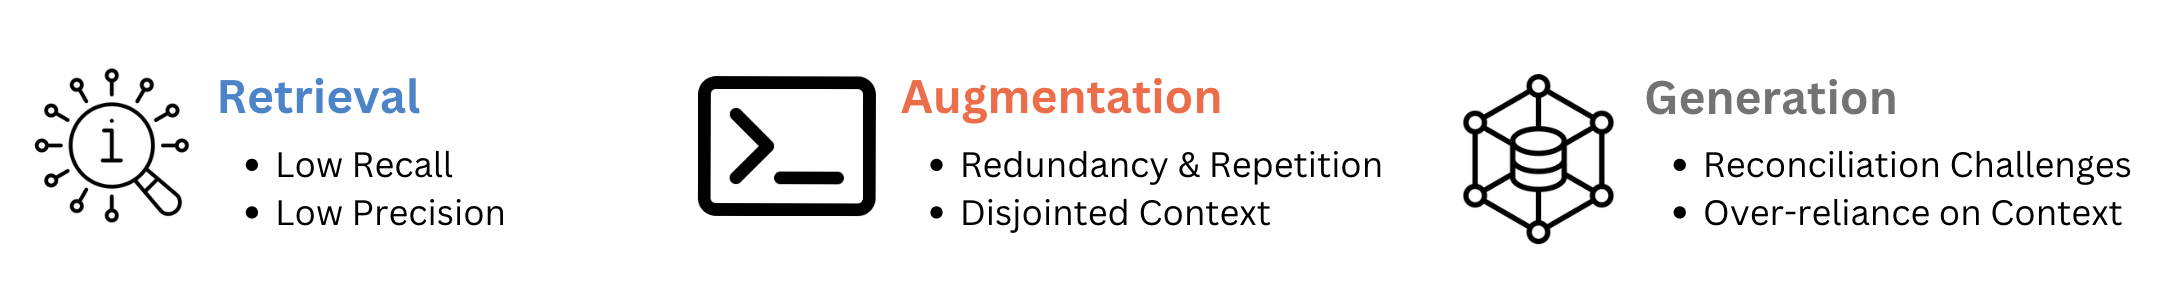

Advanced RAG Techniques
Advanced techniques in RAG have continued to emerge since the earliest experiments with Naïve RAG. There are three stages in which we can discuss these techniques –

1. Pre-retrieval Stage: Like the name suggests, there are certain interventions that can be employed before the retriever comes into action. This broadly covers two aspects - Index Optimization – The way documents are stored in the knowledge base - Query Optimization – Optimizing the user query so it aligns better to the retrieval and generation tasks
2. Retrieval Stage: Certain strategies can improve the recall and precision of the retrieval process. This goes beyond the capability of the underlying retrieval algorithms that we discussed in Chapter 4.
3. Post-retrieval Stage: Once the information has been retrieved, the context can be further optimized to better align with the generation task and the downstream LLM.

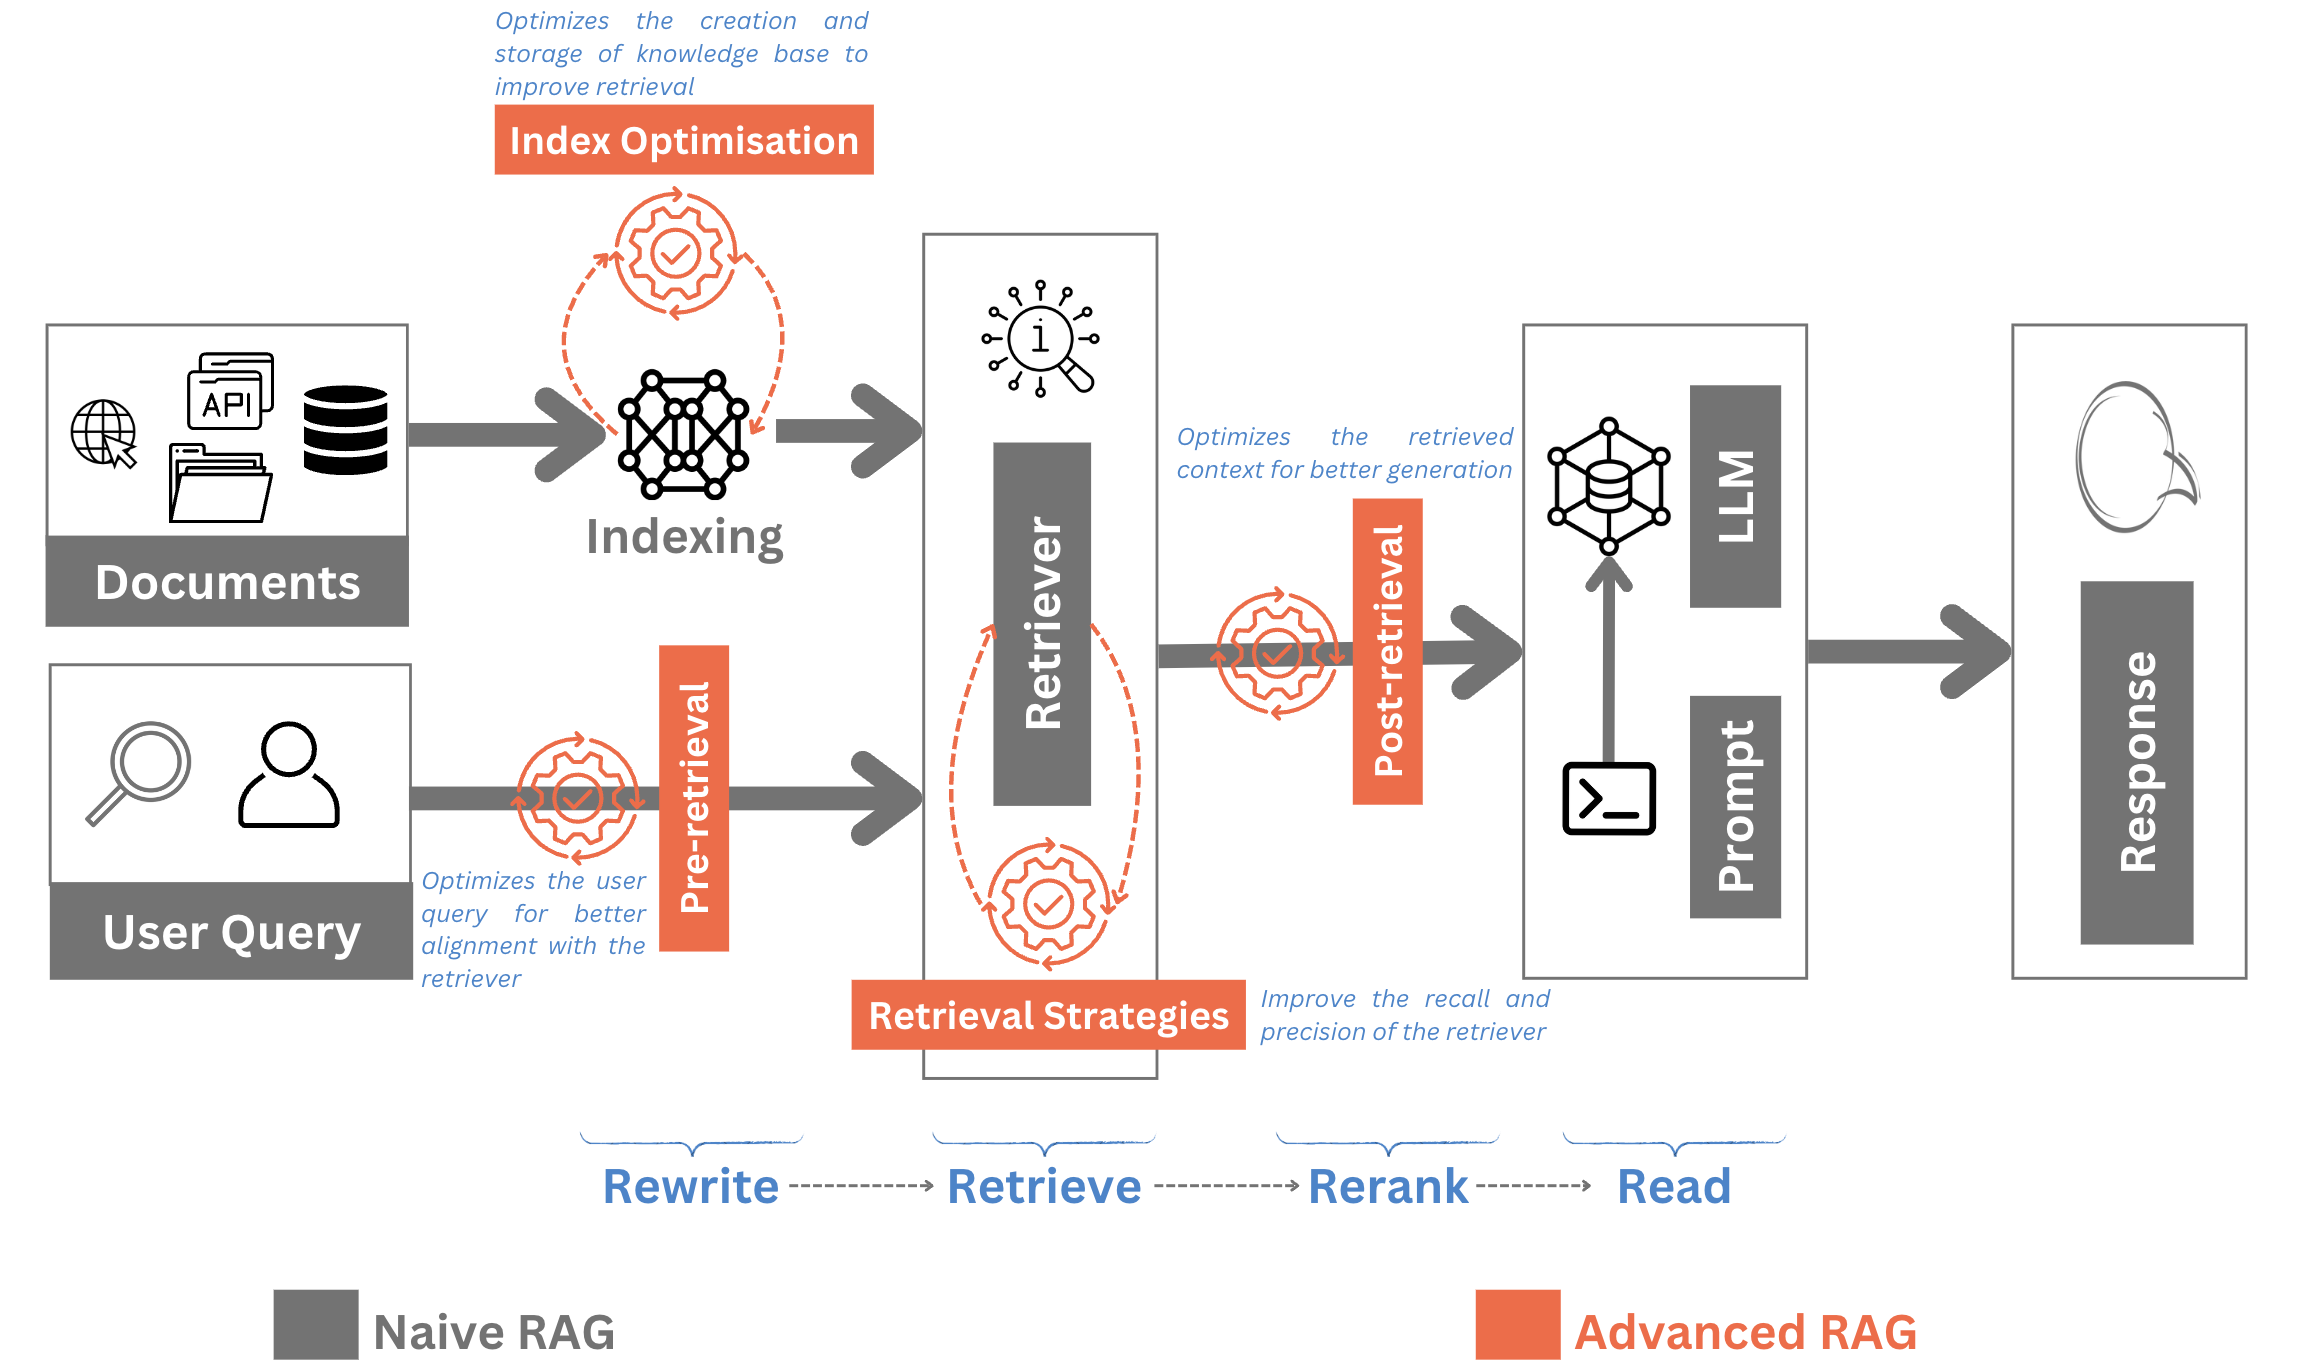


Before we start with anything lets first initialize the LLM model for chat or conversation.

In [8]:
from dotenv import load_dotenv
import os
os.environ.pop('GROQ_API_KEY',None)
if load_dotenv():
    print("Success: .env file found with some environment variables")

Success: .env file found with some environment variables


In [9]:
import os
import requests

api_key = os.environ.get("GROQ_API_KEY")
if not api_key:
    raise ValueError("GROQ_API_KEY environment variable not set.")

url = "https://api.groq.com/openai/v1/models"
headers = {
    "Authorization": f"Bearer {api_key}",
    "Content-Type": "application/json"
}

response = requests.get(url, headers=headers)
if response.status_code == 200:
    models_data = response.json()
    print("Available Groq Models:")
    for model in models_data.get('data', []):
        print(f"- {model['id']}")
else:
    print(f"Failed to fetch models: {response.status_code}, {response.text}")


Available Groq Models:
- openai/gpt-oss-20b
- meta-llama/llama-prompt-guard-2-86m
- qwen/qwen3-32b
- openai/gpt-oss-safeguard-20b
- llama-3.3-70b-versatile
- whisper-large-v3
- llama-3.1-8b-instant
- allam-2-7b
- moonshotai/kimi-k2-instruct
- meta-llama/llama-prompt-guard-2-22m
- meta-llama/llama-4-maverick-17b-128e-instruct
- meta-llama/llama-guard-4-12b
- playai-tts-arabic
- openai/gpt-oss-120b
- playai-tts
- moonshotai/kimi-k2-instruct-0905
- groq/compound
- meta-llama/llama-4-scout-17b-16e-instruct
- groq/compound-mini
- whisper-large-v3-turbo


## 1. Pre-retrieval Stage
The primary objective of employing pre-retrieval techniques is to facilitate better retrieval. Retrieval failures can happen because of 2 reasons.

__Knowledge Base is not suited for retrieval__

__Retriever doesn’t completely understand the input query__

### 1.1 INDEX OPTIMIZATION
The objective of index Optimization is to set up the knowledge base for better retrieval.

#### __Context Enriched Chunking__
<u>This method adds the summary of the larger document to each chunk to enrich the context of the smaller chunk</u>

In [10]:
# Import FAISS class from vectorstore library
from langchain_community.vectorstores import FAISS
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")


In [11]:
from langchain_community.document_loaders import AsyncHtmlLoader
from langchain_community.document_transformers import Html2TextTransformer

url="https://en.wikipedia.org/wiki/71st_National_Film_Awards"
loader = AsyncHtmlLoader (url)
data = loader.load()
html2text = Html2TextTransformer()
data_transformed = html2text.transform_documents(data)

Fetching pages: 100%|##########| 1/1 [00:00<00:00,  2.70it/s]


In [12]:
document_text=data_transformed[0].page_content

In [13]:
document_text

'Jump to content\n\nMain menu\n\nMain menu\n\nmove to sidebar hide\n\nNavigation\n\n  * Main page\n  * Contents\n  * Current events\n  * Random article\n  * About Wikipedia\n  * Contact us\n\nContribute\n\n  * Help\n  * Learn to edit\n  * Community portal\n  * Recent changes\n  * Upload file\n  * Special pages\n\nSearch\n\nSearch\n\nAppearance\n\n  * Donate\n  * Create account\n  * Log in\n\nPersonal tools\n\n  * Donate\n  * Create account\n  * Log in\n\n## Contents\n\nmove to sidebar hide\n\n  * (Top)\n\n  * 1 Selection process\n\n  * 2 Dadasaheb Phalke Award\n\n  * 3 Feature Film\n\nToggle Feature Film subsection\n\n    * 3.1 Jury\n\n    * 3.2 Golden Lotus Award\n\n    * 3.3 Silver Lotus Award\n\n    * 3.4 Regional awards\n\n    * 3.5 Special Mention\n\n  * 4 Non-Feature Film\n\nToggle Non-Feature Film subsection\n\n    * 4.1 Jury\n\n    * 4.2 Golden Lotus Award\n\n    * 4.3 Silver Lotus Award\n\n    * 4.4 Special Mention\n\n  * 5 Best Writing on Cinema\n\nToggle Best Writing on Cine

In [14]:
summary_prompt = f"Summarize the given document in a single paragraph\ndocument: {document_text}"

In [15]:

llm = ChatGroq(
    model="llama-3.3-70b-versatile", # Recommended Groq model
    temperature=0.1**50,
    max_tokens=None,
    timeout=None,
    max_retries=2
    # The api_key parameter is automatically inferred from the GROQ_API_KEY 
    # environment variable if not provided explicitly
)

messages = [("human", summary_prompt)]
# Invoke the LLM
ai_msg = llm.invoke(messages)
# Extract the answer from the response object
response = ai_msg.content

In [16]:
import textwrap
print(textwrap.fill(response,width=100))

The 71st National Film Awards, presented by the National Film Development Corporation of India, were
announced on August 1, 2025, to honor the best of Indian cinema in 2023. The awards ceremony was
held on September 23, 2025, at the Vigyan Bhawan in New Delhi, where the winners were felicitated by
the President of India, Droupadi Murmu. The film "12th Fail" won the Best Feature Film award, while
Mohanlal was honored with the Dadasaheb Phalke Award for his contributions to Indian cinema. Other
notable winners include Shah Rukh Khan and Rani Mukerji, who won their first National Awards for
their performances in "Jawan" and "Mrs. Chatterjee vs Norway," respectively. The awards also sparked
controversy, with some critics accusing the film "The Kerala Story" of spreading misinformation and
promoting a divisive ideology, despite it winning awards for Best Director and Best Cinematography.


In [17]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)
chunks=text_splitter.split_text(data_transformed[0].page_content)

In [18]:
len(chunks)

40

In [19]:
context_enriched_chunks=[response + '\n'+ chunk for chunk in chunks]

In [20]:
context_enriched_chunks

['The 71st National Film Awards, presented by the National Film Development Corporation of India, were announced on August 1, 2025, to honor the best of Indian cinema in 2023. The awards ceremony was held on September 23, 2025, at the Vigyan Bhawan in New Delhi, where the winners were felicitated by the President of India, Droupadi Murmu. The film "12th Fail" won the Best Feature Film award, while Mohanlal was honored with the Dadasaheb Phalke Award for his contributions to Indian cinema. Other notable winners include Shah Rukh Khan and Rani Mukerji, who won their first National Awards for their performances in "Jawan" and "Mrs. Chatterjee vs Norway," respectively. The awards also sparked controversy, with some critics accusing the film "The Kerala Story" of spreading misinformation and promoting a divisive ideology, despite it winning awards for Best Director and Best Cinematography.\nJump to content\n\nMain menu\n\nMain menu\n\nmove to sidebar hide\n\nNavigation\n\n  * Main page\n  *

In [21]:
len(context_enriched_chunks)

40

In [22]:
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

index = faiss.IndexFlatIP(768)

vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

vector_store.add_texts(texts=context_enriched_chunks)

['f435b4b5-fe18-4cb2-9127-31ddf28ee5e4',
 '0683b398-79cf-4ec3-b175-9b88620b27a4',
 '5e6f2cee-48fd-453d-9073-93d75eb3816f',
 '911693db-ab22-4b4a-a497-c3c76faa4752',
 '146663cf-f352-4f17-99c3-231fbf297c35',
 '42e14234-98f0-4b22-bd03-df2e66d01e2e',
 'f3401d65-fa82-4497-b843-5bea91cc6629',
 '003e95b2-f362-45c7-a462-fda6c26d3288',
 'fa6f56ab-4738-4eab-9483-f7eacd9c61ec',
 '3f4b910b-9255-4c19-896a-949d9325397c',
 '5e9b2132-e226-4369-ab7d-bb3e8a0ab827',
 'f2480ef2-6d46-44aa-809d-1fab12366d8f',
 '9054905b-663f-40a0-842b-4ae696d4e72a',
 '16d27037-5bb5-440d-811b-3b24c91a43b0',
 '7531795d-a90c-473f-95f3-7e9857a422f8',
 '03c4e915-6095-4fec-9e12-d0f6a11c969d',
 '823d6e21-c646-412a-b88b-294b60575616',
 'b8a80e3e-0287-4af0-9d17-70252ca27399',
 'de163583-f5f6-4795-80ed-e3087357be9b',
 '66d9aa34-2bd5-4f5f-a197-0ebc3fb6e408',
 'a075fd0b-ecf8-4e14-8cfa-6992e1011191',
 'e6a0e207-e355-408a-8afe-a414bf8c19db',
 'f5bc06d5-6783-44cf-8cb4-8e8d09693caf',
 'f0a0862e-ea3c-4cf6-945d-271b0360a1bb',
 '50ccf103-26f7-

In [23]:
query = "Winners of 71st National Film Awards "
retrieved_docs = vector_store.similarity_search(query, k=2)

In [24]:
print(retrieved_docs[0].page_content)

The 71st National Film Awards, presented by the National Film Development Corporation of India, were announced on August 1, 2025, to honor the best of Indian cinema in 2023. The awards ceremony was held on September 23, 2025, at the Vigyan Bhawan in New Delhi, where the winners were felicitated by the President of India, Droupadi Murmu. The film "12th Fail" won the Best Feature Film award, while Mohanlal was honored with the Dadasaheb Phalke Award for his contributions to Indian cinema. Other notable winners include Shah Rukh Khan and Rani Mukerji, who won their first National Awards for their performances in "Jawan" and "Mrs. Chatterjee vs Norway," respectively. The awards also sparked controversy, with some critics accusing the film "The Kerala Story" of spreading misinformation and promoting a divisive ideology, despite it winning awards for Best Director and Best Cinematography.
6. **^** "71st NATIONAL FILM AWARDS 2023" (PDF).
  7. **^** National Film Development Corporation of Ind

### __Metadata Enhancement__
This method adds the summary of the larger document to each chunk to enrich the context of the smaller chunk

In [25]:
import faiss
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_core.documents import Document
from langchain_community.document_loaders import AsyncHtmlLoader
from langchain_community.document_transformers import Html2TextTransformer
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_groq import ChatGroq

from langchain_huggingface import HuggingFaceEmbeddings


In [26]:
def extract_fixed_metadata_from_chunk(chunk_text):
    prompt = f"""
    Extract the following fixed metadata in JSON format from the given text:
    {{
      "player_1": "",
      "player_2": "",
      "player_3": "",
      "player_4": "",
      "player_5": "",
      "team_1": "",
      "team_2": "",
      "team_3": "",
      "team_4": "",
      "team_5": "",
      "keyword_1": "",
      "keyword_2": "",
      "keyword_3": "",
      "keyword_4": "",
      "keyword_5": ""
    }}
    Here's the text:
    {chunk_text}
    """

    llm = ChatGroq(
        model="llama-3.1-8b-instant", # Recommended Groq model
        temperature=0.1**50,
        max_tokens=None,
        timeout=None,
        max_retries=2
        # The api_key parameter is automatically inferred from the GROQ_API_KEY 
        # environment variable if not provided explicitly
    )


    json_llm = llm.bind(response_format={"type": "json_object"})


    #Craft the prompt message
    messages=[("human",prompt)]


    # Invoke the LLM
    ai_msg = json_llm.invoke(messages)
    

    
    # Extract the response in JSON format
    metadata_response = ai_msg.content
    print(metadata_response)
    try:
        # Convert the response into a dictionary
        metadata = eval(metadata_response)  # This ensures it is a valid dictionary
    except Exception as e:
        print(f"Error parsing metadata: {e}")
        metadata = {
            "player_1": "", "player_2": "", "player_3": "", "player_4": "", "player_5": "",
            "team_1": "", "team_2": "", "team_3": "", "team_4": "", "team_5": "",
            "keyword_1": "", "keyword_2": "", "keyword_3": "", "keyword_4": "", "keyword_5": ""
        }
    return metadata

### Loading -> Transforming -> Chunking

In [27]:
# Step 1: Load data from a URL (Wikipedia page)
url = "https://en.wikipedia.org/wiki/2025_Indian_Premier_League"
loader = AsyncHtmlLoader(url)
data = loader.load()

# Step 2: Transform the HTML content to plain text
html2text = Html2TextTransformer()
data_transformed = html2text.transform_documents(data)

# Step 3: Split the text into smaller chunks using RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=10000,  # Number of characters in each chunk
    chunk_overlap=200  # Number of overlapping characters between chunks
)
chunks = text_splitter.split_text(data_transformed[0].page_content)

Fetching pages: 100%|##########| 1/1 [00:00<00:00,  2.44it/s]


In [28]:
# Step 4: Initialize hugging face Embeddings model
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
# hf_embeddings = embeddings.embed_documents([chunk for chunk in chunks])

# Step 5: Initialize FAISS index for L2 (Euclidean) distance
embedding_dim = len(embedding_model.embed_query("hello world"))
# embedding_dim = len(hf_embeddings)
index = faiss.IndexFlatL2(embedding_dim)

# Step 6: Initialize the InMemoryDocstore to store documents and metadata in memory
docstore = InMemoryDocstore()

# Step 7: Create FAISS vector store using the embedding function, FAISS index, and docstore
vector_store = FAISS(
    embedding_function=embedding_model,
    index=index,
    docstore=docstore,
    index_to_docstore_id={}
)

In [29]:
# Step 8: Add chunks (documents) with extracted metadata and embeddings to FAISS vector store
documents = []
for i, chunk in enumerate(chunks):
    # Extract fixed metadata using the LLM
    extracted_metadata = extract_fixed_metadata_from_chunk(chunk)
    
    # Create a document object with both the chunk content and the extracted metadata
    document = Document(
        page_content=chunk, 
        metadata={
            "source": url, 
            "category": "2025 Indian Premier League",
            "extracted_metadata": extracted_metadata  # Store the structured metadata
        }
    )
    
    # Append the document to the list
    documents.append(document)

# Create unique IDs for each chunk
ids = [f"chunk_{i}" for i in range(len(chunks))]



{
  "player_1": "Suryakumar Yadav",
   "player_2": "Sai Sudharsan",
   "player_3": "Prasidh Krishna",
   "player_4": "",
   "player_5": "",
   "team_1": "Royal Challengers Bengaluru",
   "team_2": "Punjab Kings",
   "team_3": "Gujarat Titans",
   "team_4": "Mumbai Indians",
   "team_5": "Kolkata Knight Riders",
   "keyword_1": "Indian Premier League",
   "keyword_2": "T20 cricket",
   "keyword_3": "Board of Control for Cricket in India",
   "keyword_4": "Twenty20 International",
   "keyword_5": "ICC Code of Conduct"
}
{
  "player_1": "MS Dhoni",
   "player_2": "Ajinkya Rahane",
   "player_3": "Shreyas Iyer",
   "player_4": "Sanju Samson",
   "player_5": "Rajat Patidar",
   "team_1": "Chennai Super Kings",
   "team_2": "Kolkata Knight Riders",
   "team_3": "Punjab Kings",
   "team_4": "Rajasthan Royals",
   "team_5": "Royal Challengers Bengaluru",
   "keyword_1": "Stephen Fleming",
   "keyword_2": "Chandrakant Pandit",
   "keyword_3": "Ricky Ponting",
   "keyword_4": "Rahul Dravid",
   

In [30]:
len(documents) , len(ids)

(11, 11)

In [31]:
# Add the documents and their embeddings to the FAISS vector store
vector_store.add_documents(documents=documents, ids=ids)

['chunk_0',
 'chunk_1',
 'chunk_2',
 'chunk_3',
 'chunk_4',
 'chunk_5',
 'chunk_6',
 'chunk_7',
 'chunk_8',
 'chunk_9',
 'chunk_10']

In [32]:
# Step 9: Define a function to extract metadata from a query
def extract_fixed_metadata_from_query(query_text):
    prompt = f"""
    Extract the following fixed metadata in JSON format from the query:
    {{
      "player_1": "",
      "player_2": "",
      "player_3": "",
      "player_4": "",
      "player_5": "",
      "team_1": "",
      "team_2": "",
      "team_3": "",
      "team_4": "",
      "team_5": "",
      "keyword_1": "",
      "keyword_2": "",
      "keyword_3": "",
      "keyword_4": "",
      "keyword_5": ""
    }}
    Here's the query:
    {query_text}
    """
    

    llm = ChatGroq(
        model="llama-3.1-8b-instant", # Recommended Groq model
        temperature=0.1**50,
        max_tokens=None,
        timeout=None,
        max_retries=2
    )

    json_llm = llm.bind(response_format={"type": "json_object"})


    #Craft the prompt message
    messages=[("human",prompt)]


    # Invoke the LLM
    ai_msg = json_llm.invoke(messages)

    # Extract the response in JSON format
    metadata_response = ai_msg.content
    try:
        # Convert the response into a dictionary
        metadata = eval(metadata_response)
    except Exception as e:
        print(f"Error parsing metadata: {e}")
        metadata = {
            "player_1": "", "player_2": "", "player_3": "", "player_4": "", "player_5": "",
            "team_1": "", "team_2": "", "team_3": "", "team_4": "", "team_5": "",
            "keyword_1": "", "keyword_2": "", "keyword_3": "", "keyword_4": "", "keyword_5": ""
        }
    return metadata

In [33]:
# Step 10: Extract metadata from the query
query = "Virat Kohli records in 2025 Indian Premier League"
query_metadata = extract_fixed_metadata_from_query(query)

# Step 11: Define a metadata filter based on the query's extracted metadata
def metadata_filter(doc_metadata):
    # Use .get() to safely access keys, providing an empty string as a default if the key is missing
    query_players = {query_metadata.get(f"player_{i}", "") for i in range(1, 6)}
    query_teams = {query_metadata.get(f"team_{i}", "") for i in range(1, 6)}
    query_keywords = {query_metadata.get(f"keyword_{i}", "") for i in range(1, 6)}

    # Filter out empty strings that were added due to missing keys
    query_players = {p for p in query_players if p}
    query_teams = {t for t in query_teams if t}
    query_keywords = {k for k in query_keywords if k}

    # Assuming doc_metadata["extracted_metadata"] keys are always present or handle them similarly if not
    doc_players = {doc_metadata["extracted_metadata"].get(f"player_{i}", "") for i in range(1, 6)}
    doc_teams = {doc_metadata["extracted_metadata"].get(f"team_{i}", "") for i in range(1, 6)}
    doc_keywords = {doc_metadata["extracted_metadata"].get(f"keyword_{i}", "") for i in range(1, 6)}

    doc_players = {p for p in doc_players if p}
    doc_teams = {t for t in doc_teams if t}
    doc_keywords = {k for k in doc_keywords if k}
    
    # Check if there's any overlap between the query metadata and document metadata
    return bool(query_players & doc_players or query_teams & doc_teams or query_keywords & doc_keywords)


In [34]:
# Step 12: Perform a similarity search on the stored chunks with the metadata filter
results = vector_store.similarity_search(query=query, k=3, filter=metadata_filter)


In [35]:
# Step 13: Display the results with metadata
for doc in results:
    print(f"Document: {doc.page_content}")
    print(f"Metadata: {doc.metadata}")

Document: * * *

**Match 34**  
18 April 2025 (2025-04-18)  
19:30 (N)  
Scorecard  
---  
**Royal Challengers Bengaluru (H)**  
95/9 (14 overs) | **v** | **Punjab Kings**  
98/5 (12.1 overs)  
---|---|---  
Tim David 50* (26)  
Marco Jansen 2/10 (3 overs) |  | Nehal Wadhera 33* (19)   
Josh Hazlewood 3/14 (3 overs)  
**Punjab Kings won by 5 wickets**  
M. Chinnaswamy Stadium, Bengaluru  
Umpires: Ulhas Gandhe (Ind) and Virender Sharma (Ind)  
Player of the match: Tim David (Royal Challengers Bengaluru)  
---  
  
  * Punjab Kings won the toss and elected to field.
  * The match was reduced to 14 overs per side due to rain.
  * Manoj Bhandage (Royal Challengers Bengaluru) made his IPL debut.[73]

* * *

**Match 35**  
19 April 2025 (2025-04-19)  
15:30 (D/N)  
Scorecard  
---  
**Delhi Capitals**  
203/8 (20 overs) | **v** | **Gujarat Titans (H)**  
204/3 (19.2 overs)  
---|---|---  
Axar Patel 39 (32)  
Prasidh Krishna 4/41 (4 overs) |  | Jos Buttler 97* (54)   
Kuldeep Yadav 1/30 (4 

### 1.2 __QUERY OPTIMIZATION__
The objective of this stage is to optimize the input user query in a manner that makes it better suited for the retrieval tasks

__Query Expansion__\
In query expansion, the original user query is enriched with the aim of retrieving more relevant information. This helps in increasing the recall of the system and overcomes the challenge of incomplete or very brief user queries.

In [36]:
original_query="How does RAM affect the performance of CPU ?"
num=5

In [37]:
response_structure='''
{
    "queries": [
        {
            "query": "query",
    },
    ...
]}
'''

In [38]:
expansion_prompt=f"Generate {num} variations of the following query: {original_query}. Respond in JSON format.\Stick to this Structure :\n{response_structure}"

<>:1: SyntaxWarning: "\S" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\S"? A raw string is also an option.
<>:1: SyntaxWarning: "\S" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\S"? A raw string is also an option.
/var/folders/mm/63k15_ws007cj6mjbyxwt_7m0000gp/T/ipykernel_48950/22333251.py:1: SyntaxWarning: "\S" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\S"? A raw string is also an option.
  expansion_prompt=f"Generate {num} variations of the following query: {original_query}. Respond in JSON format.\Stick to this Structure :\n{response_structure}"


In [39]:
step_back_expansion_prompt = f"Given the query: '{original_query}', generate a more abstract, higher-level conceptual query."

In [40]:
sub_query_expansion_prompt=f"Break down the following query into {num} sub-queries targeting different aspects of the query: '{original_query}'. Respond in JSON format."

In [41]:
from groq import Groq

client= Groq()
response = client.chat.completions.create(
    # Use a suitable Groq model, e.g., "llama3-8b-8192" or "mixtral-8x7b-32768"
    model="llama-3.1-8b-instant", 
    messages=	[
    {"role": "user", "content": expansion_prompt}
  		],
          response_format={ "type": "json_object" }
)

# Extract the answer from the response object
answer=response.choices[0].message.content

In [42]:
print(answer)

{
  "queries":[
      {
         "query":"How does the amount of RAM impact the speed of CPU execution?"
      },
      {
         "query":"What influence does RAM have on CPU processing power?"
      },
      {
         "query":"In what ways does the RAM capacity affect CPU performance?"
      },
      {
         "query":"How does the RAM size impact CPU efficiency?"
      },
      {
         "query":"What is the relationship between RAM and CPU processing speed?"
      }
   ]
}


In [43]:
def response_return(prompt):
    response = client.chat.completions.create(
    # Use a suitable Groq model, e.g., "llama3-8b-8192" or "mixtral-8x7b-32768"
    model="llama-3.1-8b-instant", 
    messages=	[
    {"role": "user", "content": prompt}
  		]
    )

    # Extract the answer from the response object
    answer=response.choices[0].message.content
    return answer

In [44]:
print(response_return(sub_query_expansion_prompt))

Here's a breakdown of the query into 5 sub-queries targeting different aspects of the query:

```json
{
  "subQueries": [
    {
      "id": 1,
      "query": "What is the relationship between RAM and CPU performance?",
      "description": "This sub-query explores the fundamental relationship between RAM and CPU performance, including how RAM affects CPU processing power.",
      "keyWords": ["CPU", "RAM", "performance"]
    },
    {
      "id": 2,
      "query": "How does RAM capacity impact CPU performance?",
      "description": "This sub-query examines the impact of RAM capacity on CPU performance, including the optimal RAM size and the effects of insufficient or excessive RAM.",
      "keyWords": ["RAM capacity", "CPU performance", "optimal RAM size"]
    },
    {
      "id": 3,
      "query": "What is the effect of RAM speed (MHz) on CPU performance?",
      "description": "This sub-query investigates the relationship between RAM speed (MHz) and CPU performance, including the imp

In [45]:
print(response_return(step_back_expansion_prompt))

Here's a more abstract, higher-level conceptual query based on the given question:

"How does the CPU-memory interface influence the overall system processing throughput and efficiency, and what are the implications for application performance and resource allocation?"

This query moves beyond the specific components of CPU and RAM, and instead focuses on the broader system-level interactions and performance implications, encouraging a more holistic understanding of the relationship between these components.


__Query Transformation__\
Compared to query expansion, in query transformation, instead of the original user query retrieval happens on a transformed query which is more suitable for the retriever

In [46]:
original_query="How does RAM affect the performance of CPU ?"
system_prompt="You are an expert in memory management and process efficiency."

In [47]:
hyde_prompt=f"Generate an answer to the question: {original_query}"

In [48]:
response = client.chat.completions.create(
    # Use a suitable Groq model, e.g., "llama3-8b-8192" or "mixtral-8x7b-32768"
    model="llama-3.1-8b-instant", 
    messages=	[
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": hyde_prompt}
  ]
)
# Extract the answer from the response object
answer=response.choices[0].message.content

In [49]:
print(answer)

The relationship between RAM (Random Access Memory) and CPU (Central Processing Unit) performance is crucial for understanding how a computer system functions. In essence, RAM plays a pivotal role in enhancing CPU performance by providing a temporary storage area for data. Here's a detailed explanation:

**How RAM Affects CPU Performance:**

1. **Cache Memory Integration**: CPU's cache memory is typically faster and smaller than regular RAM. However, the CPU also draws from the system's RAM if needed for processing information. RAM, in turn, reduces the need for frequent cache memory lookups, thereby improving CPU processing speed.
2. **Data Access Speed**: RAM provides rapid access to data stored in it, allowing the CPU to quickly retrieve the necessary information for processing. If RAM is limited, the CPU may experience slower data access times, resulting in reduced performance.
3. **Overhead Reduction**: With sufficient RAM, the CPU doesn't have to waste processing time on disk I/O

In [50]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

# Create embedding for the hypothetical answer
hyde_embedding = embeddings.embed_query(answer)

# Check and print the dimension of the embedding
embedding_dimension = len(hyde_embedding)
print(f"The embedding dimension is: {embedding_dimension}")

The embedding dimension is: 768


### 2. __Retrieval Strategies__
Interventions in the pre-retrieval stage can bring significant improvements in the performance of the RAG system if the query and the knowledge base becomes well aligned with the retrieval algorithm.

__Hybrid Retrieval__

In [51]:
import faiss
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.documents import Document
from langchain_community.document_loaders import AsyncHtmlLoader
from langchain_community.document_transformers import Html2TextTransformer
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.retrievers import BM25Retriever

# Step 1: Load data from a URL (Wikipedia page)
url = "https://en.wikipedia.org/wiki/2025_Indian_Premier_League"
loader = AsyncHtmlLoader(url)
data = loader.load()

# Step 2: Transform the HTML content to plain text
html2text = Html2TextTransformer()
data_transformed = html2text.transform_documents(data)

# Step 3: Split the text into smaller chunks using RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,  # Number of characters in each chunk
    chunk_overlap=200  # Number of overlapping characters between chunks
)
chunks = text_splitter.split_text(data_transformed[0].page_content)


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  2.18it/s]


In [52]:
# Step 4: Dense Retrieval (FAISS + OpenAI Embeddings)

# Initialize OpenAI Embeddings model for dense retrieval
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

# Initialize FAISS index for dense retrieval
embedding_dim = len(embedding_model.embed_query("hello world"))
index = faiss.IndexFlatL2(embedding_dim)

# Create an in-memory document store to support adding documents
docstore = InMemoryDocstore()

# Initialize FAISS vector store
vector_store = FAISS(embedding_function=embedding_model, index=index, docstore=docstore, index_to_docstore_id={})

# Add chunks to FAISS vector store
documents = [Document(page_content=chunk) for chunk in chunks]
vector_store.add_documents(documents)

# Step 5: Sparse Retrieval (BM25 using LangChain's BM25Retriever)

# Initialize BM25Retriever
bm25_retriever = BM25Retriever.from_documents(documents)



In [53]:
# Step 6: Hybrid Retrieval Strategy

def hybrid_search(query, k=5):
    # Step 6.1: Perform dense retrieval using FAISS
    dense_results = vector_store.similarity_search(query=query, k=k)
    
    # Step 6.2: Perform sparse retrieval using BM25Retriever
    sparse_results = bm25_retriever.get_relevant_documents(query)
    
    # Limit sparse results to top-k
    sparse_results = sparse_results[:k]
    
    # Step 6.3: Combine dense and sparse results
    combined_results = []
    for dense_doc in dense_results:
        combined_results.append(("dense", dense_doc.page_content))

    for sparse_doc in sparse_results:
        combined_results.append(("sparse", sparse_doc.page_content))

    # Optionally, re-rank or further process combined results
    return combined_results



In [54]:
# Step 7: Perform a hybrid search
query = "Virat Kohli records in 2025 Indian Premier League"
hybrid_results = hybrid_search(query)

# Step 8: Display the results
for retrieval_type, result in hybrid_results:
    print(f"Retrieval Type: {retrieval_type}")
    print(f"Result: {result}\n")

Retrieval Type: dense
Result: 2025 Indian Premier League  
---  
Dates| 22 March – 3 June 2025  
Administrator| Board of Control for Cricket in India  
Cricket format| Twenty20  
Tournament format(s)| Group stage and playoffs  
Champions| Royal Challengers Bengaluru (1st title)  
Runners-up| Punjab Kings  
Participants| 10  
Matches| 74  
Most valuable player| Suryakumar Yadav (Mumbai Indians)  
Most runs| Sai Sudharsan (Gujarat Titans) (759)  
Most wickets| Prasidh Krishna (Gujarat Titans) (25)

Retrieval Type: dense
Result: 58. **^** 2025 Indian Premier League points table standings at ESPNcricinfo. Archived from the original on 27 June 2025. Retrieved 3 June 2025.
  59. **^** "IPL 2025: Who is Aniket Verma? Hard-Hitting Player making debut in IPL for Sunrisers Hyderabad". _mykhel.com_. Retrieved 23 March 2025.
  60. **^** "No T20 experience? No problem for MI's Vignesh Puthur, who stood out on his IPL debut". ESPNcricinfo. Retrieved 24 March 2025.

Retrieval Type: dense
Result: 101.

### 3. __Post Retrieval Stage__
At the post-retrieval stage the approaches of reranking and compression help in providing better context to the LLM for generation.

__Compression__\
In prompt compression, language models are used to detect and remove unimportant and irrelevant tokens

In [55]:
document_to_compress=retrieved_docs[0].page_content

In [56]:
compress_prompt = f"Compress the following document into very short sentences, retaining only the extremely essential information:\n\n{document_to_compress}"

In [57]:
print(textwrap.fill(response_return(compress_prompt), width=80))

The 71st National Film Awards ceremony was held on September 23, 2025. Key
winners include:  - "12th Fail" (Best Feature Film) - Mohanlal (Dadasaheb Phalke
Award) - Shah Rukh Khan (National Award for "Jawan") - Rani Mukerji (National
Award for "Mrs. Chatterjee vs Norway")  The awards also sparked controversy
regarding the film "The Kerala Story."


In [58]:
print(textwrap.fill(document_to_compress, width=80))

The 71st National Film Awards, presented by the National Film Development
Corporation of India, were announced on August 1, 2025, to honor the best of
Indian cinema in 2023. The awards ceremony was held on September 23, 2025, at
the Vigyan Bhawan in New Delhi, where the winners were felicitated by the
President of India, Droupadi Murmu. The film "12th Fail" won the Best Feature
Film award, while Mohanlal was honored with the Dadasaheb Phalke Award for his
contributions to Indian cinema. Other notable winners include Shah Rukh Khan and
Rani Mukerji, who won their first National Awards for their performances in
"Jawan" and "Mrs. Chatterjee vs Norway," respectively. The awards also sparked
controversy, with some critics accusing the film "The Kerala Story" of spreading
misinformation and promoting a divisive ideology, despite it winning awards for
Best Director and Best Cinematography. 6. **^** "71st NATIONAL FILM AWARDS 2023"
(PDF).   7. **^** National Film Development Corporation of Ind